In [123]:
# Load important libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

In [124]:
# Read the US_Arrests file
arrests = pd.read_csv('UsArrests.csv',index_col='City')

# Introduction

### US Arrests Lists Description

The dataset aims to analyze the relationship between different crimes and urban population in various states in the United States. It provides a snapshot of crime statistics and population characteristics across different locations.

By analyzing this dataset, one can gain insights into crime patterns and potentially identify correlations between crime rates and urban population. It can be used for exploratory data analysis, statistical modeling, and understanding factors influencing crime rates in different cities. Likelihood of various crimes occuring at certain states can also be evaluated using a machine learning technique.

### Purpose of PCA

The purpose of perfoming a PCA on the US_Arrests dataset is to simplify the dataset, identify key features, visualise the dta, and improve the efficiency of the subsequent anaylis and modelling tasks. It will provide a insights into the relationships between different crimes and their impact on the dataset for modelling purposes. The purpsoe of the PCA can be summarised as follows:
* Dimensionality Reduction
* Identifying Key Features
* Visualising Data
* Data Preprocessing

# US_Arrests List Description

### Introduction and Data Description

The "US_Arrests" dataset provides information on various crimes across different cities in the United States. It consists of five columns where the first column is a unique identifier representing states:
* City: The name of the city where the crime data was recorded. (Nominal)
* Murder: The number of murders per 100,000 inhabitants in the city. (Ratio)
* Assault: The number of assaults per 100,000 inhabitants in the city. (Ratio)
* UrbanPop: The percentage of the urban population in the city. (Ratio)
* Rape: The number of rapes per 100,000 inhabitants in the city. (Ratio)

In [125]:
print(f'''\nThe first few rows are:
      {arrests.head()}''')
print(f'''\nThe last few rows are:
      {arrests.tail()}''')


The first few rows are:
                  Murder  Assault  UrbanPop   Rape
City                                        
Alabama     13.200      236        58 21.200
Alaska      10.000      263        48 44.500
Arizona      8.100      294        80 31.000
Arkansas     8.800      190        50 19.500
California   9.000      276        91 40.600

The last few rows are:
                     Murder  Assault  UrbanPop   Rape
City                                           
Virginia        8.500      156        63 20.700
Washington      4.000      145        73 26.200
West Virginia   5.700       81        39  9.300
Wisconsin       2.600       53        66 10.800
Wyoming         6.800      161        60 15.600


Lets examine the size of the data to be analysed.

In [126]:
print(f'Number of states or observations: {arrests.shape[0]}. Number of variables or features: {arrests.shape[1]}')

Number of states or observations: 50. Number of variables or features: 4


### Structure of Data (Format & Type)

We observe that Assault and Uburn Population variables have integer values compared to Murder and Rape variables which are floating points. One would expect all variables to be either floating points or integers as per the data capturer's prefered precision settings. 

This difference of data types (numerical data types) is unlikely to affect analytical modelling below.

In [127]:
# Dataframe columns and the data types stored in these columns
print(arrests.info())

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB
None


### Statistical Summary

We look at a statistical summary of the dataset variables or features to gain a quick glace at a few common statistical variables.

The statistics reveals that the popularity offenders. Assault is a very common offence comapred to both rape and murder and is likely to have light sentences on offenders.

In [128]:
# A statistical descriptive overview of the data 
stats = arrests.describe(include = 'all')
stats

,Murder,Assault,UrbanPop,Rape
count,50.000,50.000,50.000,50.000
mean,7.788,170.760,65.540,21.232
std,4.356,83.338,14.475,9.366
min,0.800,45.000,32.000,7.300
25%,4.075,109.000,54.500,15.075
50%,7.250,159.000,66.000,20.100
75%,11.250,249.000,77.750,26.175
max,17.400,337.000,91.000,46.000


### Text Preprocessing

The City names are long and can be abbreviated using 2 letter state codes or abbreviations.

The abbreviations make for a better visualisation on the biplots below.

In [129]:
# For better visualisation on charts, introduce abbreviated state or city names (All 50 states abbrv.)
arrests['CityAbbrv'] = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA',
                        'HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
                        'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
                        'NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
                        'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

# Set the abbreviated names as row indices
arrests = arrests.set_index('CityAbbrv')

print(f'''\nThe first few rows are:
      {arrests.head()}''')
print(f'''\nThe last few rows are:
      {arrests.tail()}''')


The first few rows are:
                 Murder  Assault  UrbanPop   Rape
CityAbbrv                                  
AL         13.200      236        58 21.200
AK         10.000      263        48 44.500
AZ          8.100      294        80 31.000
AR          8.800      190        50 19.500
CA          9.000      276        91 40.600

The last few rows are:
                 Murder  Assault  UrbanPop   Rape
CityAbbrv                                  
VA          8.500      156        63 20.700
WA          4.000      145        73 26.200
WV          5.700       81        39  9.300
WI          2.600       53        66 10.800
WY          6.800      161        60 15.600


# Standard Data Quality Dimensions

### Validity

The statistics indicated below show that all numbers are positive as expected. For percentage of Urban population there is not a percentage that is greater than 100%, indicating that this variable has valid entries.

In [130]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Select relevant statistical rows
selected_stats = stats.loc[["mean","std","min","max"]].transpose() 
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


### Missing Values

It is important to find out if there is any missing data on the data set and the type of missingness thereof. The type of missingness will assist in dertemining possible ways of imputation should it be required.

There are no missing values in the data set.

In [131]:
# Columns with missing data
print('The Number of missing Data values are tabulated below:\n')
print(pd.DataFrame(arrests.isnull().sum(), columns=['Missing']))

The Number of missing Data values are tabulated below:

          Missing
Murder          0
Assault         0
UrbanPop        0
Rape            0


### Data Consistency

In [132]:
# See if there are any duplicated observations
print('\nDuplicated observations are:\n\n', arrests.loc[arrests.duplicated()])


Duplicated observations are:

 Empty DataFrame
Columns: [Murder, Assault, UrbanPop, Rape]
Index: []


### Outliers

It is important to find outliers and handle them so as to avoid introducing noise in the model. 

The number of reported rape cases in the United States has 2 excessively high cases. Although this represents 4% of the rape varibles being excessively high, these outlier must be handled. 

We cannot confirm if the outliers are as a result of incorrect recordings or if they represent the actual figures. A periodical record such as that of a yearly recorded arrests might give a clear indication. However, a quick research agrees with these high numbers.

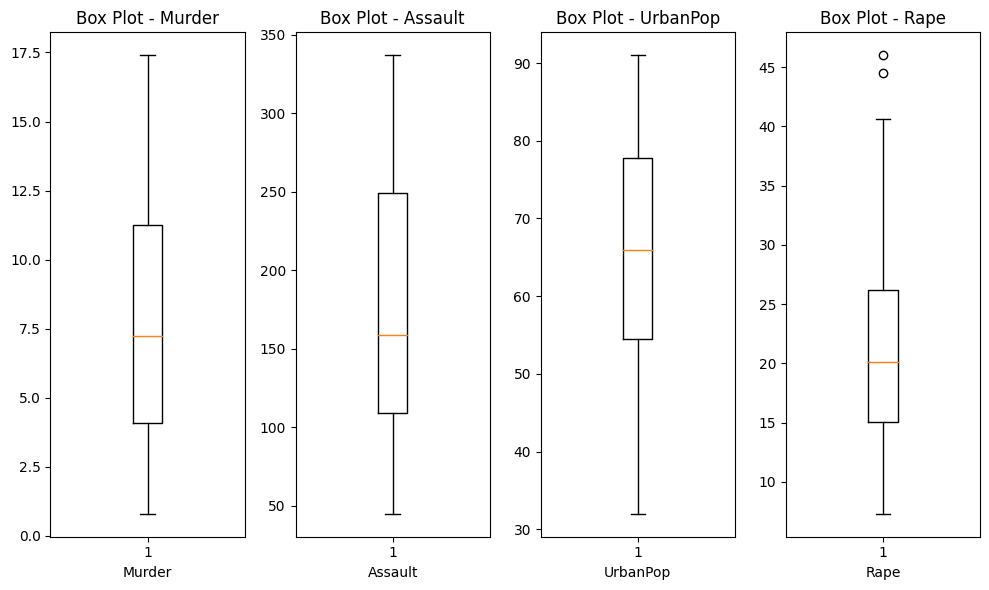

In [133]:
# Create figure 
plt.figure(figsize=(10, 6))

# Iterate over each numerical variable  
for i, col in enumerate(arrests.columns):
    plt.subplot(1, len(arrests.columns), i+1)
    plt.boxplot(arrests[col])
    plt.xlabel(col)
    plt.title(f'Box Plot - {col}')

plt.tight_layout()
plt.show()

The states of Alaska and Nevada have very high records for rape cases. All 3 crimes are very high for the two states and are above 75th percentile values. Poor law enforcement could be a contributing factor to these righ crime rates.

In [134]:
# Calculate quartiles and IQR of athlete earnings over 3 decades
rapes = arrests['Rape']
Q1, Q3 = rapes.quantile([0.25, 0.75])
IQR = Q3 - Q1
upper_Q, lower_Q = Q3 + IQR * 1.5, Q1 - IQR * 1.5

# Create a list of 'Outliers' and 'Non-Outliers' from 'rapes
high_rape = ['Outlier' if rape_arrest > upper_Q or rape_arrest < lower_Q else 'Non-Outlier' for rape_arrest in rapes]

# Copy the original arrests and add a new column to indicate outliers
outliers_df = arrests.assign(Outliers=high_rape)

# Show the states with high rape arrests
print('\nStates below have high rape crimes')
outliers_df[outliers_df['Outliers'] =='Outlier']


States below have high rape crimes


,Murder,Assault,UrbanPop,Rape,Outliers
CityAbbrv,,,,,
AK,10.00,263,48,44.50,Outlier
NV,12.20,252,81,46.00,Outlier


In [135]:
# For better accuracy of the model to be created later, replace the outliers using the upper quantile
print(f'The maximum number of rape cases is to be: {upper_Q}')
arrests['Rape'].mask(arrests['Rape'] >= upper_Q, 0 , inplace=True)

The maximum number of rape cases is to be: 42.825


# Data Insights

### Pairwise Relationships

A look at the Murder and Assault scatterplot reveals that there is positive correlation between the 2 variables. Assault and Rape also positivey correlate to a lessor extent compared to that of Murder and Assault. The occurence of rape is slightly positively correlated to urburn population with seemingly a cap to the number of rape cases for a specific urban population percentage. Urban population shows little correlation to murder and assualt cases.

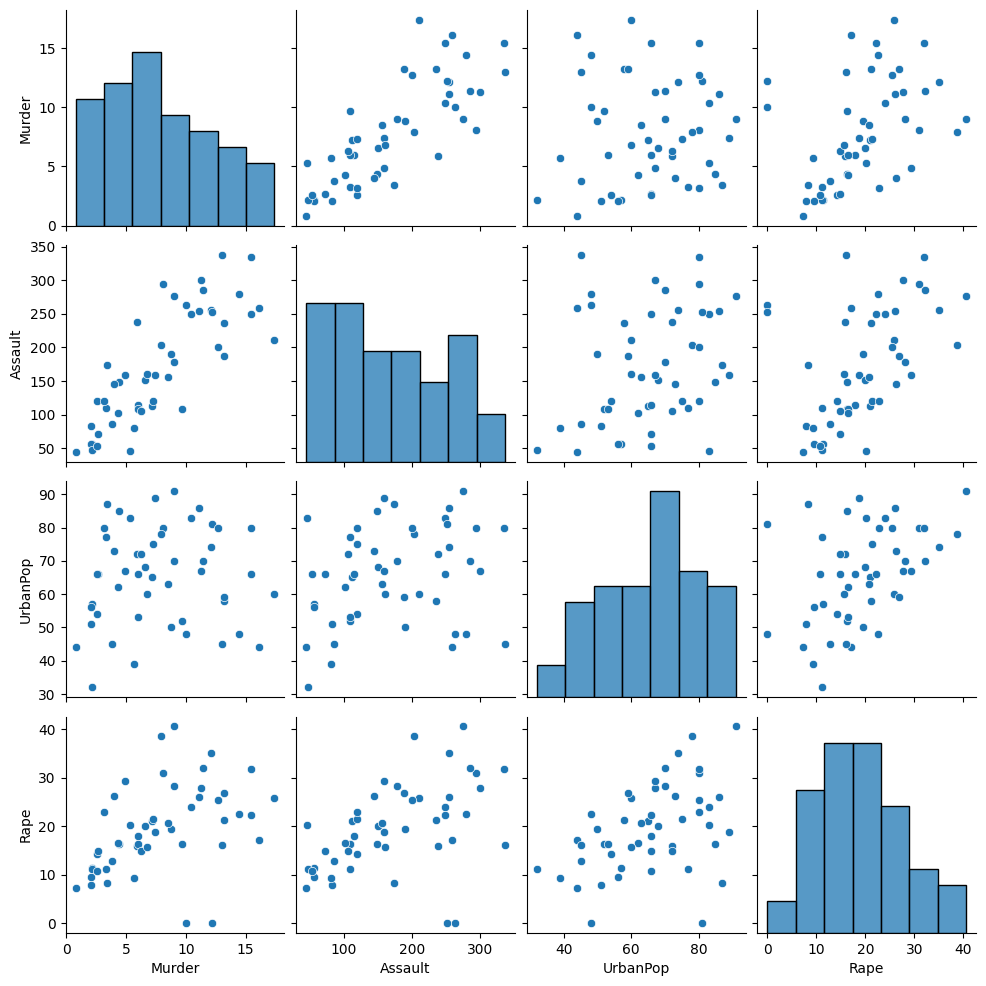

In [136]:
# Pairwise Scatter Plot
sns.pairplot(arrests)
plt.show()

### Distribution of Crime and Urban Population

The histograms below show the distribution of the number of states over the number of cases reported for each crime. For all crimes, there is not a single one with normally distributed cases.

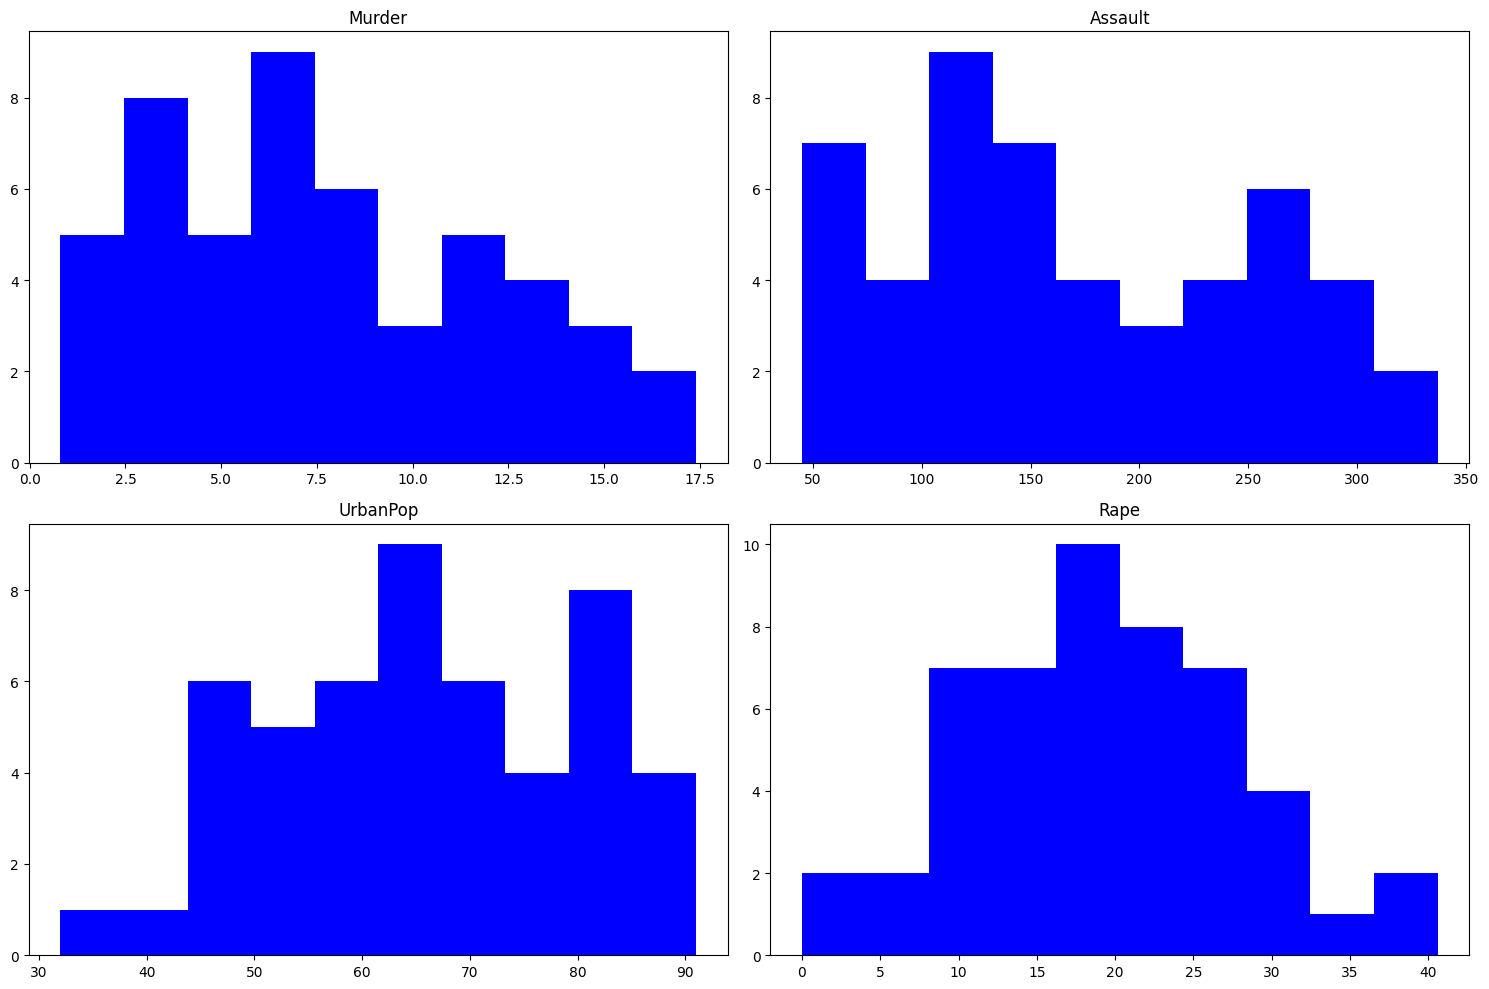

In [137]:
# Plot histograms
histograms = arrests.hist(color='blue', grid=False, figsize=(15, 10), bins=10) 
plt.tight_layout()
plt.show()

### Correletion of Varaibles

The correlation matrix below confirms the observations on the pairwise scatter plots above. Areas that are dominated by violence or assault are likely to have high murder rates. In layman terms, murder can be viewed as assault that ends with the victim losing thier life. 

The positive correletion between rape and assault shows that areas with high assault cases have high number of rape cases reported as well. This also indicates that some victims are assaulted and raped in one case. Lets note that sexual assault is considered rape in this data set.

The correlation between murder and rape indicates that despite having more information on the data that say so, some of the murder victims had been raped before/while being murdered.

High rape crimes seem to be happening in urban areas. Rural areas usually consist of scattered homesteads and far from public services administration including the police, hence, rape maybe unreported. 

With murder being a very serious offence, it always gets reported regardless of where it happens. Due to other legal requirements from home affairs departments, it is unlikley that a person is laid to rest without compiling neccessary legal documentation (e.g. death certificates).

Minor correlation of about 0.3 is observed between assault cases and urban population. Assault in rural areas may go unreported due to cultural beliefs and stigmatisation of violence especially against women and children.

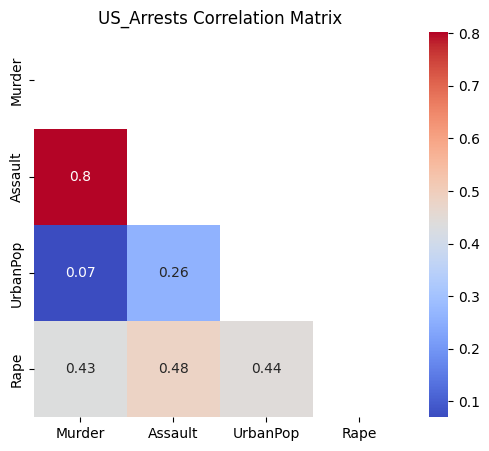

In [138]:

features = arrests.index # Retrieve feature names

# correlations = corr_df.corr()

# Select only the feature columns
feature_columns = arrests.iloc[:,:]

# Calculate the correlation matrix
correlation_matrix = feature_columns.corr()

labels = correlation_matrix.columns 

# Create an upper triangular matrix filled with boolean ones
mask_ut=np.triu(np.ones(correlation_matrix.shape)).astype(bool)

# Plot correlation heat map with the upper triangle masked with booleans
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, mask=mask_ut, annot=True, cmap='coolwarm')
plt.title('US_Arrests Correlation Matrix')
plt.show()

## PCA

## PCA: Unstandardised Data

In [139]:
# run again if it does not converge the first time
# Remove single dimensionality of the arrest array
X = arrests.values.squeeze()

pca = PCA()

# Fit the model on variables and apply dimensionality reduction on the variables
X_trans = pca.fit_transform(X)

# Create a dataframe of the PCA transformed data
df_pca = pd.DataFrame(X_trans)

# First 5 rows of the PCA transformed data set
df_pca.head()

,0,1,2,3
0,64.99,10.72,-1.45,2.13
1,90.20,27.36,17.68,-1.09
2,124.12,-9.95,-2.16,-4.68
3,18.50,16.06,-3.45,-0.76
4,107.23,-24.06,-9.31,-3.13


In [140]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = points[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html
    # Accessed on 03/07/2023

The biplot below shows that Assault and Urban Population have high importance with assault having the highest importance on the model. 

These variables also have high mean values from the statistics calculated above. There it is likelihood that these high mean values have an impact on the PCA. We will therefore, standardise variables in the next section.

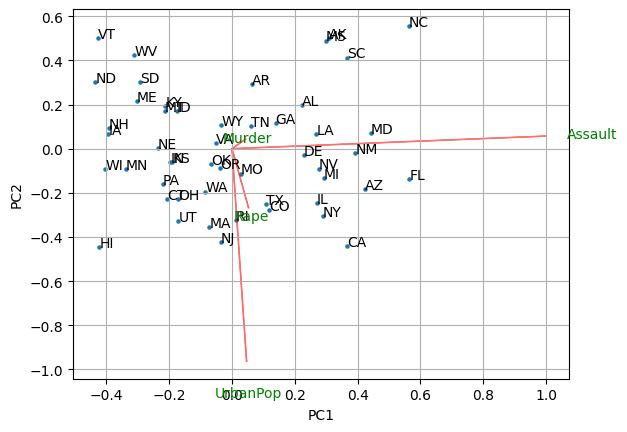

In [141]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2,:]),list(labels),list(features))
plt.show()

In [142]:
# Feature importance Function
def feature_df(pca_df):
    pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

    pc1 = abs(pca_df.components_[0]) #components x features - access at index 0 to get the first component
    pc2 = abs(pca_df.components_[1])

    feat_df = pd.DataFrame()
    feat_df["PC1 Importance"] = pc1
    feat_df["PC2 Importance"] = pc2

    feat_df = feat_df.set_index(labels)
    return feat_df

In [143]:
# Unstandardised Feature Importance
feature_df(pca)

,PC1 Importance,PC2 Importance
Murder,0.042,0.042
Assault,0.997,0.057
UrbanPop,0.046,0.962
Rape,0.052,0.266


## PCA: Standardised Data

In [144]:
# Scale features using a standard scaler
X_scaled = StandardScaler().fit_transform(feature_columns.values)

In [145]:
pca_sc = PCA()

# Fit the model on variables and apply dimensionality reduction on the variables
X_trans_sc = pca_sc.fit_transform(X_scaled)

# Create a dataframe of the PCA transformed data
df_pca_sc = pd.DataFrame(X_trans_sc)

# First 5 rows of the PCA transformed data set
df_pca_sc.head()

,0,1,2,3
0,1.084,1.141,-0.034,0.203
1,-0.571,2.199,1.558,-0.532
2,1.903,-0.772,-0.067,-0.872
3,-0.075,1.017,-0.450,-0.208
4,2.685,-1.682,-0.598,-0.493


The biplot below shows that all features are important as opposed to the unstandardised PCA which showed that Assault and Urban population were far more important than others. This shows the importance of scaling features for PCA modelling.

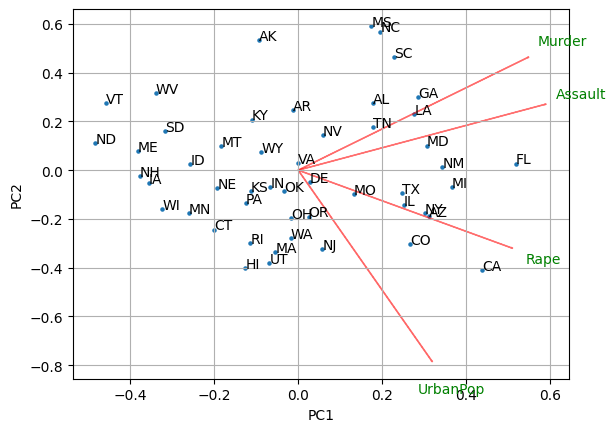

In [146]:
biplot(X_trans_sc[:,0:2],np.transpose(pca_sc.components_[0:2,:]),list(labels),list(features))
plt.show()

In [147]:
# Standardised Feature Importance
feature_df(pca_sc)

,PC1 Importance,PC2 Importance
Murder,0.546,0.462
Assault,0.586,0.270
UrbanPop,0.318,0.783
Rape,0.507,0.319


Text(0.5, 1.0, 'Cumulative Explained Variance')

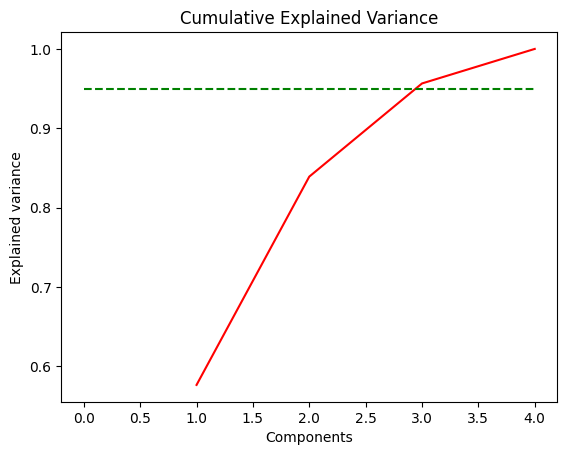

In [148]:
# Cumulative variance plot
exp_var_ratios = pca_sc.explained_variance_ratio_

# Feature values of the X axis
feature_values = range(1,len(exp_var_ratios)+1)

# Get the indices of explained variance ratios
feature_indices = arrests.index

# Calculate cumulative sum of explained variance ratios
cum_exp_var = np.cumsum(exp_var_ratios)

# Make a line graph
plt.plot(feature_values, cum_exp_var, c='red')

# Plot a 95% line of importance
plt.hlines(y = 0.95, xmin=0, xmax=len(exp_var_ratios), color = 'g', linestyles = 'dashed')

# Format x ticks and labels
# plt.xticks(feature_values, important_feature_columns, rotation = 'vertical')

plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.title("Cumulative Explained Variance")

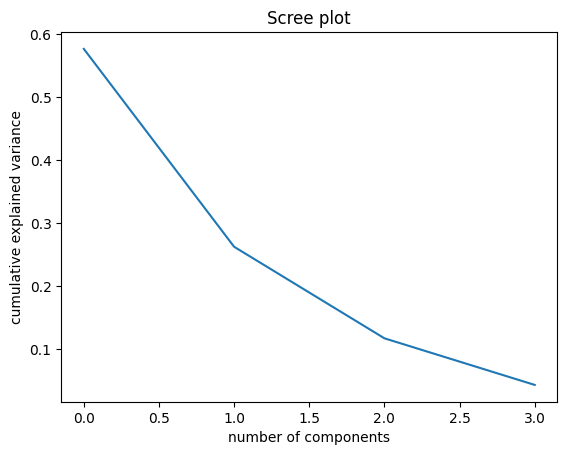

In [149]:
# Scree plot
plt.plot(exp_var_ratios)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

In [150]:
pca_df = pd.DataFrame(X_trans_sc[:,0:4], index = arrests.index)
pca_df.head()

,0,1,2,3
CityAbbrv,,,,
AL,1.084,1.141,-0.034,0.203
AK,-0.571,2.199,1.558,-0.532
AZ,1.903,-0.772,-0.067,-0.872
AR,-0.075,1.017,-0.450,-0.208
CA,2.685,-1.682,-0.598,-0.493


## Hierarchical clustering

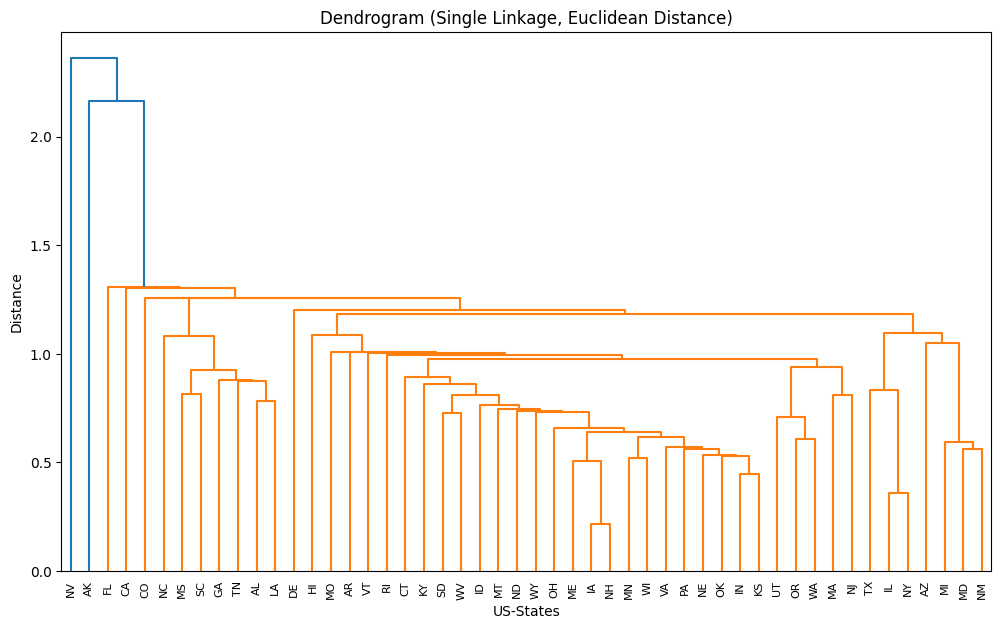

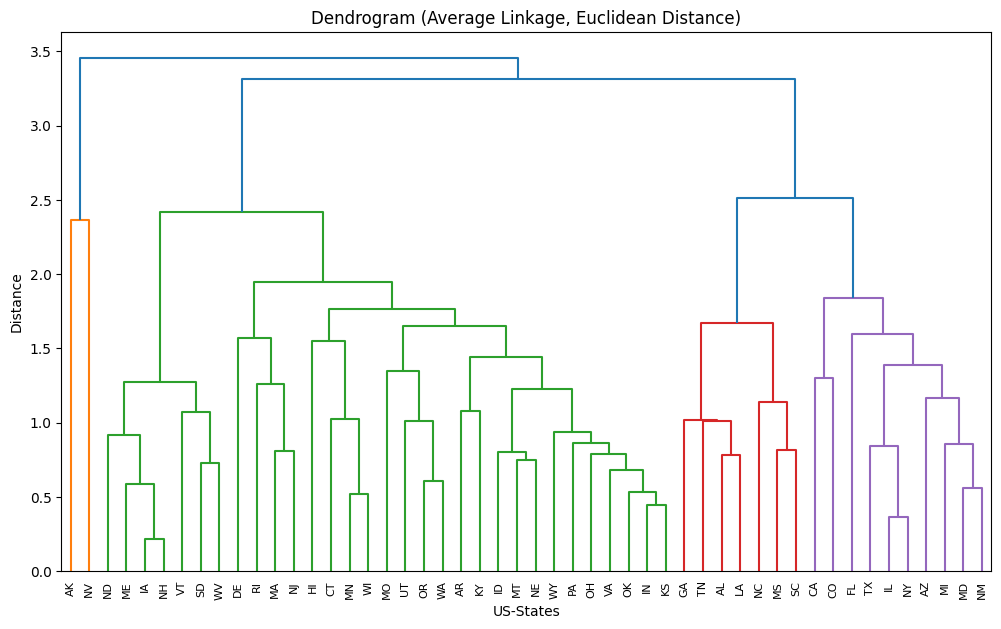

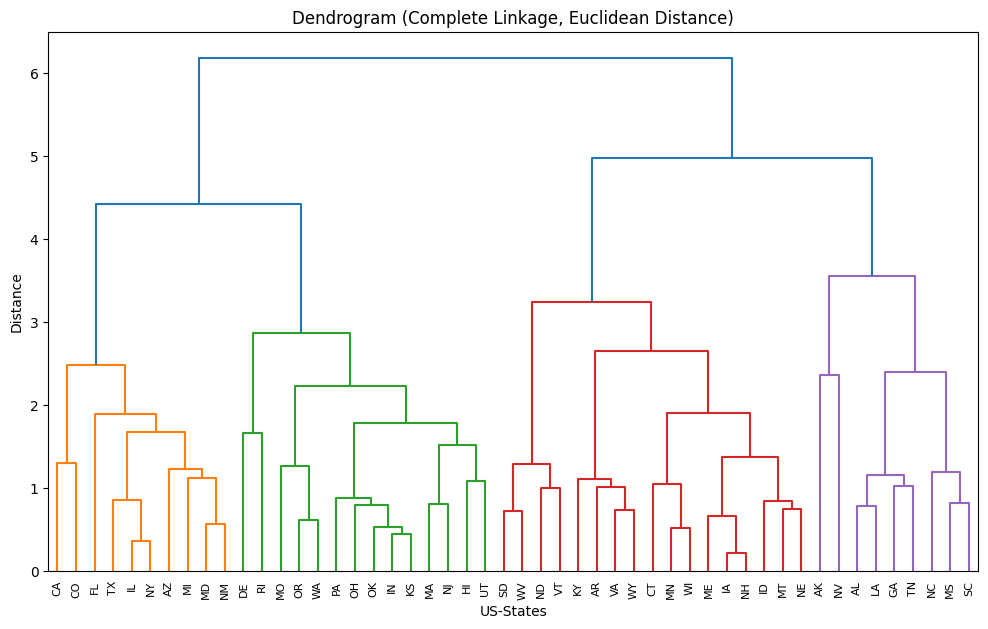

In [151]:
# Enlist types of linkage methods and distance metrics
linkage_types = ['single', 'average', 'complete']
distance_metrics = ['euclidean']

# Create dendrograms for each combination
for link_type in linkage_types:
    for dist_metric in distance_metrics:
        # Perform hierarchical clustering for each method and metric
        link = linkage(X_trans_sc, method=link_type, metric=dist_metric)

        # Plot the dendrogram
        plt.figure(figsize=(12, 7))
        plt.title(f"Dendrogram ({link_type.capitalize()} Linkage, {dist_metric.capitalize()} Distance)")
        dendrogram(link, labels=arrests.index)
        
        plt.xlabel("US-States")
        plt.ylabel("Distance")
        plt.show()

The complete linkage dendogram with euclidean distance nicely classifies the states into 4 categories.

## K-means clustering

C:\Users\Fortune\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


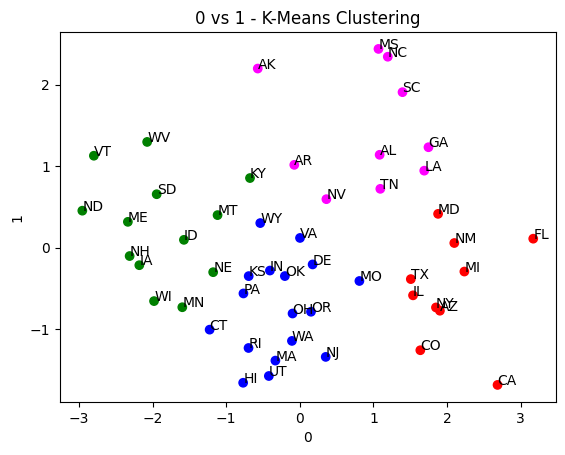

Accuracy for 0 vs 1: 0.43


In [89]:
# Define custom colors
custom_colors = ['red', 'green', 'blue', 'magenta']

# Create a custom color map
color_map = ListedColormap(custom_colors)

# Get the feature columns for clustering
feature1, feature2 = 0, 1

# Create a subset dataframe with the selected features
data_subset = X_trans_sc[:, [feature1, feature2]]

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_subset)

# Get the cluster labels
labels = kmeans.labels_

# Calculate accuracy using silhouette_score
silhouette = round(silhouette_score(data_subset, labels, metric='euclidean'),2)

# Plot clusters
fig, ax = plt.subplots()

# Plot the scatter plot with cluster colors
ax.scatter(data_subset[:, 0], data_subset[:, 1], c=labels, cmap=color_map)

ax.set_title(f'{feature1} vs {feature2} - K-Means Clustering')
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)

for i in range(0,len(X_trans_sc[:, [feature1]])):
        txt = arrests.index[i]
        ax.annotate(txt, (X_trans_sc[i, [feature1]], X_trans_sc[i, [feature2]]))

plt.show()

# Print the accuracy if true labels are available
print(f"Accuracy for {feature1} vs {feature2}: {silhouette}")
    

In [122]:
print(arrests.loc[['SD','GA', 'AL', 'MI'],:])

           Murder  Assault  UrbanPop   Rape
CityAbbrv                                  
SD          3.800       86        45 12.800
GA         17.400      211        60 25.800
AL         13.200      236        58 21.200
MI         12.100      255        74 35.100


Magenta coloured cluster represents states with high Murder and Assault arrests. These are the most dangerous states to live in.

Green coloured cluster represtes the safest states to live in with lower Murder, Rape and Assault cases. These are mostly rural areas.

Blue coloured cluster represents states with high urban populations. Assault is average in these states but Murder is low.

Red states are also urban areas that have high Rape and Assault cases.